残差网络（ResNet）

随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。  
更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力， 为了取得质的突破，我们需要一些数学基础知识

函数类

首先，假设有一类特定的神经网络架构$\digamma$，它包括学习速率和其他超参数设置。 对于所有$f \in \digamma$，存在一些参数集（例如权重和偏置），  
这些参数可以通过在合适的数据集上进行训练而获得。 现在假设$f^{*}$是我们真正想要找到的函数，如果是$f^{*} \in \digamma$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。   
相反，我们将尝试找到一个函数$f_{\digamma}^{*}$，这是我们在$\digamma$中的最佳选择。  
例如，给定一个具有$X$特性和$y$标签的数据集，我们可以尝试通过解决以下优化问题来找到它：  
$$f_{\digamma}^{*}:=argmin \quad L(X,y,f) \\ subject \quad to \quad f \in \digamma$$

那么，怎样得到更近似真正$f^{*}$的函数呢？ 唯一合理的可能性是，我们需要设计一个更强大的架构$\digamma '$。   
换句话说，我们预计$f_{\digamma '}^{*}$比$f_{\digamma}^{*}$“更近似”。 然而，如果$\digamma ⊈ \digamma ‘$，则无法保证新的体系“更近似”。  
事实上，$f_{\digamma '}^{*}$可能更糟： 如 图7.6.1所示，对于非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^{*}$靠拢（复杂度由$\digamma _1$向$\digamma _6$递增）。  
在 图7.6.1的左边，虽然$\digamma _3$比$\digamma _1$更接近$f^{*}$，但$\digamma _6$却离的更远了。 相反对于 图7.6.1右侧的嵌套函数（nested function）类$\digamma _1 \subseteq \digamma _2 ... \subseteq \digamma _6$，我们可以避免上述问题。  

意思是当前面的层是这样的一种映射：$x+g_1(x)+g_2(x)...+g_k(x)$  
当后面再进行叠加时，希望得到这样的效果：$x+g_1(x)+g_2(x)...+g_k(x)+g_{k+1}(x)$  
保留了前面的效果(恒等映射)，并且加入了一小部分增加性能的函数  
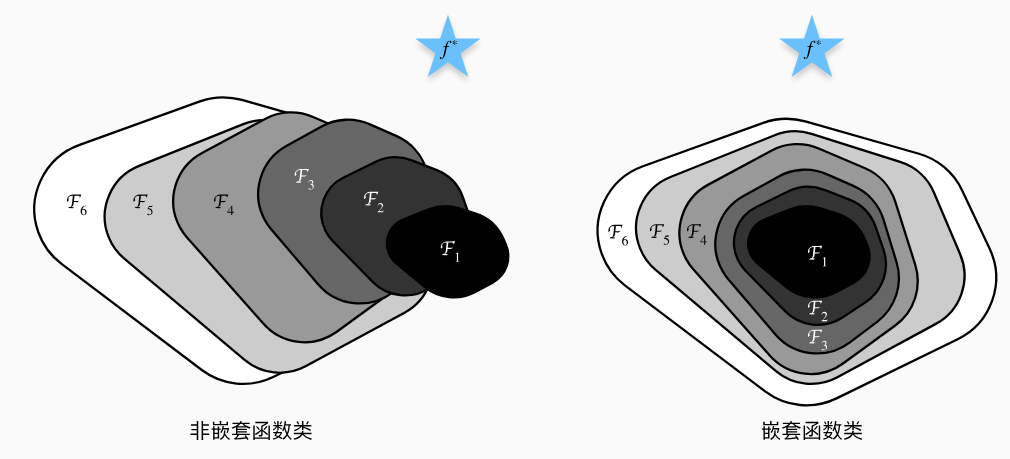

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。  
对于深度神经网络，如果我们能将新添加的层训练成恒等映射（identity function）$f(X)=X$，新模型和原模型将同样有效。  
同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

针对这一问题，何恺明等人提出了残差网络（ResNet） (He et al., 2016)。  
它在2015年的ImageNet图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。  
残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。  
于是，残差块（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。  
凭借它，ResNet赢得了2015年ImageNet大规模视觉识别挑战赛。

让我们聚焦于神经网络局部：如图 图7.6.2所示，假设我们的原始输入为x，而希望学出的理想映射为$f(x)$（作为 图7.6.2上方激活函数的输入）。  
图7.6.2左图虚线框中的部分需要直接拟合出该映射，而右图虚线框中的部分则需要拟合出残差映射$f(x)-x$。残差映射在现实中往往更容易优化。  
以本节开头提到的恒等映射作为我们希望学出的理想映射$f(x)$，我们只需将 图7.6.2中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(x)$即为恒等映射。  
实际中，当理想映射$f(x)$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。  
图7.6.2右图是ResNet的基础架构–残差块（residual block）。 在残差块中，输入可通过跨层数据线路更快地向前传播。  
令$f(x)-x=g(x)$，有$f(x)=g(x)+x$,其中x是恒等映射，$g(x)$是增加性能的部分  

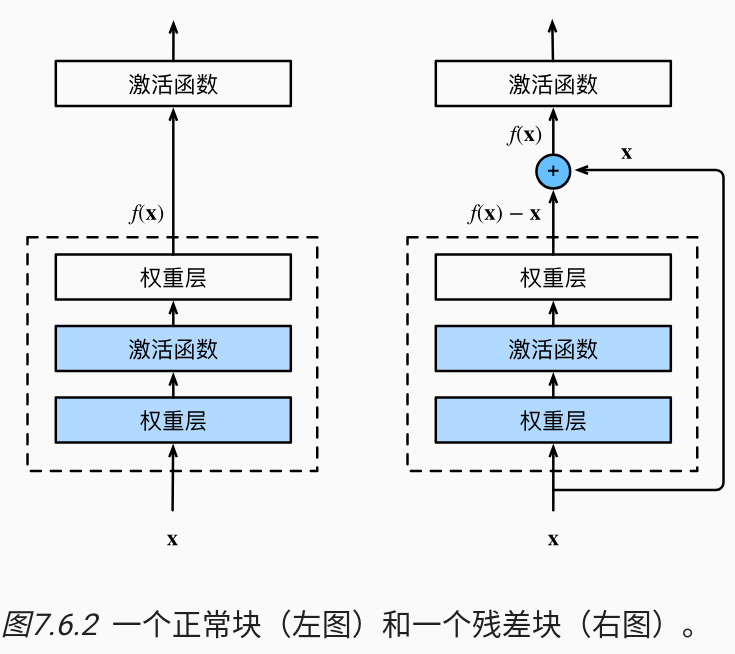

ResNet沿用了VGG完整的3\*3卷积层设计。 残差块里首先有2个有相同输出通道数的3\*3卷积层。   
每个卷积层后接一个批量规范化层和ReLU激活函数。 然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。   
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。   
如果想改变通道数，就需要引入一个额外的卷积层来将输入变换成需要的形状后再做相加运算。  
残差块的实现如下：

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        #(in_size-(k-1)+2*p+s-1)/s=(in_size+s-1)/s=out1
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        #(out1+s-1)/s=out1=out2=(in_size+s-1)/s
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
            #(in_size+s-1)/s=out3=out1=out2
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        #out1=(in_size+s-1)/s
        Y = self.bn2(self.conv2(Y))
        #out1=(in_size+s-1)/s
        if self.conv3:
            X = self.conv3(X)
            #out1=(in_size+s-1)/s
        Y += X

        return F.relu(Y)

如 图7.6.3所示，此代码生成两种类型的网络：  
一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。  
另一种是当use_1x1conv=True时，添加通过1*1卷积调整通道和分辨率。  
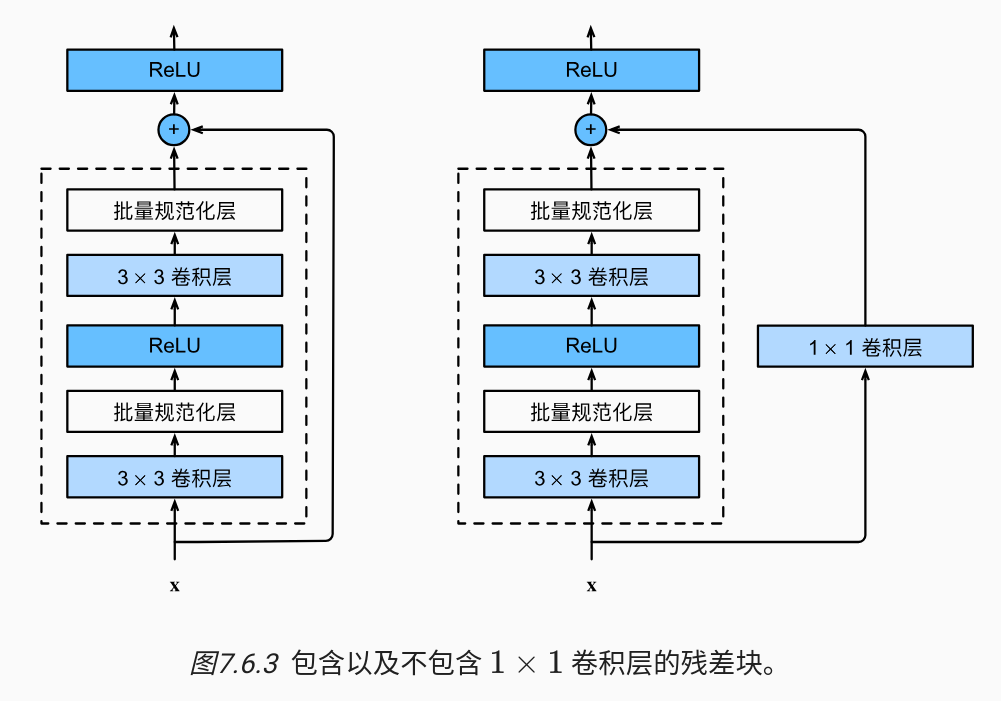

In [12]:
#下面我们来查看输入和输出形状一致的情况。
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape


torch.Size([4, 3, 6, 6])

我们也可以在增加输出通道数的同时，减半输出的高和宽。  
注意，增加chanel时必须要加1*1卷积来调整加和x的chanel数量，但是strides可选可不选，  
输出的形状为[batchsize , num_chanel , (in_size+strides-1)/strides , ---]

In [ ]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape


torch.Size([4, 6, 3, 3])

ResNet模型  
ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的7\*7卷积层后，  
接步幅为2的3*3的最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层。  
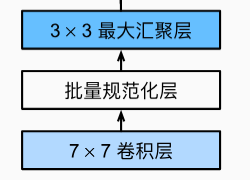

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    # (224-(7-1)+2*3+2-1)/2=112
                    nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
                    # (112-(3-1)+2*1+2-1)/2=56


GoogLeNet在后面接了4个由Inception块组成的模块。  
ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。  
第一个模块的通道数同输入通道数一致,并且形状保持不变。  
由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。  
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            #不是第一个块，第一层会执行这部分，形状减半，并且输入输出chanel可以不同
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            #第一个块只执行这部分，形状不变，并且输入输出chanel必须相同
            blk.append(Residual(num_channels, num_channels))
    return blk


In [ ]:
#接着在ResNet加入所有残差块，这里每个模块使用2个残差块。
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
#形状保持不变56
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
#形状/8=7


In [ ]:
#最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    #直接将输入的形状转换为传入的shape形状，chanel保持不变
                    #batch_size,512,1,1
                    nn.Flatten(), nn.Linear(512, 10))


每个模块有4个卷积层（不包括恒等映射的1\*1卷积层）。 加上第一个7\*7卷积层和最后一个全连接层，共有18层。  
因此，这种模型通常被称为ResNet-18。 通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。  
虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。 图7.6.4描述了完整的ResNet-18。  
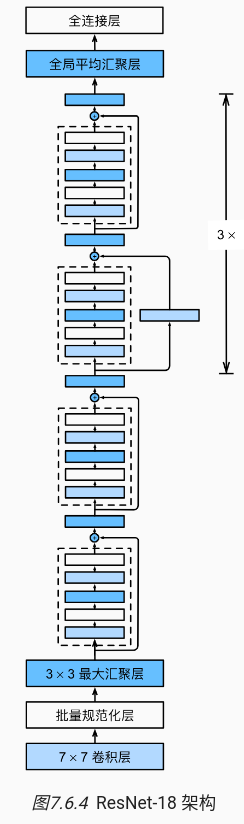

在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [18]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


训练模型

同之前一样，我们在Fashion-MNIST数据集上训练ResNet。

train_loss 0.027,test_loss 0.401, train acc 0.993, test acc 0.890
746.1 examples/sec on cuda:0


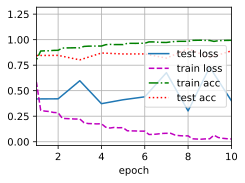

In [19]:
lr, num_epochs, batch_size = 0.05, 10, 512
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
